In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import pymc3 as pm
import theano.tensor as T
from theano.compile.ops import as_op
import theano



# Bayesian Network Models in PyMC3 and NetworkX
## Taken from PMML 4.3

We start with a simple network having several continuous and several discrete (categorical) distributions. We have to define the conditional probabilities for each case in the categorical nodes. 

<img src="http://dmg.org/pmml/v4-3/BNExampleModel.png" alt="alt text" width="400" height="400" align="left">

$D_1$   | Probability
-----|-------
0	 |    0.3
1    |	  0.7

$D_2$	| Probability
----|----
0	| 0.6
1	| 0.3
2	| 0.1
   

| D_1=0	| D_1=1
|------------|----------------------|----
|P$(C_1|D_1)$ |	\mathcal{N}$(10,2)|	$\mathcal{N}$(14,2)|

|| $D_2$=0	| $D_2$=1  | $D_2$=2
|------------|----------------------|----
|P$(C_2|D_2)$ |	$\mathcal{N}$(6,2)|	$\mathcal{N}$(8,1)| $\mathcal{N}$(14,1)|


$$P(C_4 | C_2) = $\mathcal{N}$(0.1 C_2^2 + 0.6C_2 + 1, 2)$$

|| $D_3$=0	| $D_3$=1
|------------|----------------------|----
|P$(C_3|C_2)$ |	$\mathcal{N}$(0.15C_2^2,2)|	$\mathcal{N}$(0.15C_2,1)|


|<td colspan=3>$D_1$=0 <td colspan=3>$D_1$=1
|-
|$D_3$ | $D_2$ = 0 | $D_2$ = 1 | $D_2$ = 2 | $D_2$ = 0 | $D_2$ = 1 | $D_2$ = 2
|0	| 0.1 | 0.3 | 0.4 | 0.6	| 0.8 | 0.9
|1	| 0.9 |	0.7 | 0.6 | 0.4 | 0.2 | 0.1

|<td colspan=3>$D_3$=0</td> <td colspan=3>$D_3$=1</td>
|-
|$D_3$ | $C_3$ < 9 | 9 < $C_3$ < 11 | $C_3$ > 11 | $C_3$ < 9 | 9 < $C_3$ < 11 | $C_3$ > 11
|0 | 0.4 | 0.3 | 0.6 | 0.4 | 0.1 | 0.3
|1 | 0.6 | 0.7 | 0.4 | 0.6 | 0.9 | 0.7


In [5]:
d1_prob = np.array([0.3,0.7])  # 2 choices
d2_prob = np.array([0.6,0.3,0.1])  # 3 choices
d3_prob = np.array([[[0.1, 0.9],  # (2x3)x2 choices
                     [0.3, 0.7], 
                     [0.4, 0.6]], 
                    [[0.6, 0.4], 
                     [0.8, 0.2],
                     [0.9, 0.1]]])
d4_prob = np.array([[[0.4, 0.6],  # (2x3)x2 choices
                     [0.6, 0.4],
                     [0.3, 0.7]],
                    [[0.4, 0.6], 
                     [0.3, 0.7],
                     [0.1, 0.9]]])

c1_mu, c1_sd = np.array([[10, 14],  # 2 choices inherit
                         [2 , 2 ]])
c2_mu, c2_sd = np.array([[6, 8, 14],  # 3 choices inherit
                         [2, 1, 1 ]])


## Standard Approach in PyMC3
First we will build up the network using variable instantiation for each node. The "edges" here are really just indications that the distribution parameters are conditional upon the node's parents. 

I haven't been able to quite figure out a fast way of getting the inequality conditionals to work in Theano without using an ugly "switch" statement (node `C3`'s discretization for `C4`'s conditions). But, this works faster in Theano than a long python if-else block for now. 

Additionally, it's possible to write the combination of distributions into a continuous node in terms of a `NormalMixture()`, where the discrete parents are drawn from a `Dirichlet()` prior. Technically possible, but causes an inexplicable 
```
python.exe has stopped working
``` 
on my system (and python crashes on Linux, too), so maybe that will work out eventually as updates are rolled out. 

In [6]:
with pm.Model() as model:
    
    D1 = pm.Categorical('D1',p=d1_prob)
    D2 = pm.Categorical('D2',p=d2_prob)
    
    C1 = pm.Normal('C1',mu = 10 + 4*D1, tau = (1./2)**2)
#     p1 = pm.Dirichlet('p1', d1_prob)                     # inexplicable failure
#     C1 = pm.NormalMixture('C1', p1, mu=c1_mu, sd=c1_sd)  # inexplicable failure
    
    C2 = pm.Normal('C2',mu=6+2*(D2**2), tau=1)
#     p2 = pm.Dirichlet('p2', d2_prob)                     # inexplicable failure
#     C2 = pm.NormalMixture('C2', p2, mu=c2_mu, sd=c2_sd)  # inexplicable failure
    
    D3_prob = theano.shared(d3_prob)  # make numpy-->theano
    D3_0 = D3_prob[D1, D2]  # select the prob array that "happened" thanks to parents
    D3 = pm.Categorical('D3',p=D3_0)

    C3 = pm.Normal('C3',mu = (0.15*(C2**2)*(1-D3) + 1.5*C2*D3), tau=(1./(2-D3))**2)
    C4 = pm.Normal('C4',mu = 0.1*C2**2 + 0.6*C2+1, tau = 0.25, observed = [7])
    
#     C3_0 = np.select([T.lt(C3,9), T.gt(C3,9) & T.lt(C3,11), T.gt(C3,11)], [0,1,2])  # doesnt work in Theano
    C3_0 = T.switch(T.lt(C3,9), 0, 
                   T.switch(T.gt(C3, 9) & T.lt(C3,11), 1, 2))  # ugly (and hard to generalize)

    D4_prob = theano.shared(d4_prob)  # make numpy-->theano   
    D4_0 = D4_prob[D3, C3_0]  # select the prob array that "happened" thanks to parents
        
    D4 = pm.Categorical('D4', p=D4_0, observed=[0])

# Create MCMC object

In [7]:
with model:
    trace = pm.sample(10000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryGibbsMetropolis: [D1, D3]
>CategoricalGibbsMetropolis: [D2]
>NUTS: [C3, C2, C1]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:30<00:00, 681.16draws/s]
The acceptance probability does not match the target. It is 0.8795492901781978, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


         mean        sd  mc_error   hpd_2.5   hpd_97.5        n_eff      Rhat
C1  12.962940  2.656175  0.039561  7.652842  17.855775  4898.561515  1.000046
C2   5.720620  0.794939  0.009261  4.191574   7.327479  7720.813610  0.999950
C3   6.751576  2.553340  0.032836  1.692044  10.983675  4379.349618  1.001044


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1f2c1780>,
      dtype=object)

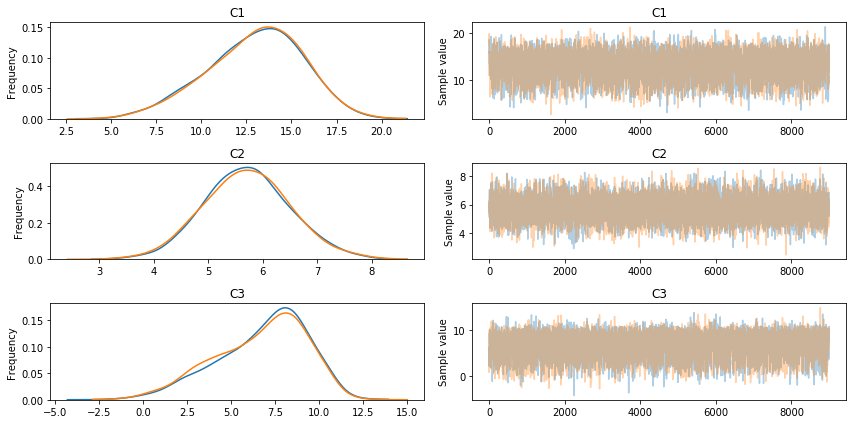

In [12]:
print (pm.stats.summary(trace, varnames=['C1', 'C2', 'C3'], start=10))
pm.traceplot(trace[1000:], varnames=['C1', 'C2', 'C3'])

Not bad. So, let's do something a bit more sophisticated. Eventually, it would be nice to create a PyMC3 BayesNet on the fly, reading in a specification (like PMML, for example!) and generating/running the theano model. The 'pythonic' way to do programmatic variable instantiation is to use a dictionary...and one of my other favorite packages is essentially a package for graphs built on dicts!


## NetworkX with PyMC3

The interesting thing here is that 
- pymc3 works this way, and even though it really should, somehow I'm amazed it worked first try, no errors. yay!
- we can pre-define the entire network, with all of the necessary data as graph (node or edge) attributes...
- letting us apply PyMC3 distribution objects *later on*. 

The fully parsed version of this from some schema like PMML doesnt exist yet, so treat the following as a proof of concept:

In [13]:
import networkx as nx


In [14]:
d1_prob = np.array([0.3,0.7])  # 2 choices
d2_prob = np.array([0.6,0.3,0.1])  # 3 choices
d3_prob = np.array([[[0.1, 0.9],  # (2x3)x2 choices
                     [0.3, 0.7], 
                     [0.4, 0.6]], 
                    [[0.6, 0.4], 
                     [0.8, 0.2],
                     [0.9, 0.1]]])
d4_prob = np.array([[[0.4, 0.6],  # (2x3)x2 choices
                     [0.6, 0.4],
                     [0.3, 0.7]],
                    [[0.4, 0.6], 
                     [0.3, 0.7],
                     [0.1, 0.9]]])

c1_mu, c1_sd = np.array([[10, 14],  # 2 choices inherit
                         [2 , 2 ]])
c2_mu, c2_sd = np.array([[6, 8, 14],  # 3 choices inherit
                         [2, 1, 1 ]])


BN = nx.DiGraph()

BN.add_node('D1', dtype='Discrete', prob=d1_prob, pos=(2, 4))
BN.add_node('D2', dtype='Discrete', prob=d2_prob, pos=(4, 4))

BN.add_node('C1', dtype='Continuous', mu=c1_mu, sd=c1_sd, pos=(1,3))
BN.add_edge('D1', 'C1')
BN.add_node('C2', dtype='Continuous', mu=c2_mu, sd=c2_sd, pos=(5,3))
BN.add_edge('D2', 'C2')

BN.add_node('D3', dtype='Discrete', prob = d3_prob, pos=(3, 3))
BN.add_edges_from([('D1', 'D3'), ('D2', 'D3')])

BN.add_node('C3', dtype='Continuous', pos=(4, 2))
BN.add_edges_from([('D3', 'C3'), ('C2', 'C3')])

BN.add_node('C4', dtype='Continuous', observe=np.array([7.]), pos=(6, 2))
BN.add_edge('C2', 'C4')

BN.add_node('D4', dtype='Discrete', prob=d4_prob, observe=np.array([0.]), pos=(2, 1))
BN.add_edges_from([('D3', 'D4'), ('C3', 'D4')])

Let's make sure things are looking right...for example, the parents of the `C4` node are...

In [16]:
print (BN.nodes(data=True))
print (BN.pred['C4'])
# [BN.node[i] for i in BN.predecessors_iter('D4')]


[('D1', {'dtype': 'Discrete', 'prob': array([0.3, 0.7]), 'pos': (2, 4)}), ('D2', {'dtype': 'Discrete', 'prob': array([0.6, 0.3, 0.1]), 'pos': (4, 4)}), ('C1', {'dtype': 'Continuous', 'mu': array([10, 14]), 'sd': array([2, 2]), 'pos': (1, 3)}), ('C2', {'dtype': 'Continuous', 'mu': array([ 6,  8, 14]), 'sd': array([2, 1, 1]), 'pos': (5, 3)}), ('D3', {'dtype': 'Discrete', 'prob': array([[[0.1, 0.9],
        [0.3, 0.7],
        [0.4, 0.6]],

       [[0.6, 0.4],
        [0.8, 0.2],
        [0.9, 0.1]]]), 'pos': (3, 3)}), ('C3', {'dtype': 'Continuous', 'pos': (4, 2)}), ('C4', {'dtype': 'Continuous', 'observe': array([7.]), 'pos': (6, 2)}), ('D4', {'dtype': 'Discrete', 'prob': array([[[0.4, 0.6],
        [0.6, 0.4],
        [0.3, 0.7]],

       [[0.4, 0.6],
        [0.3, 0.7],
        [0.1, 0.9]]]), 'observe': array([0.]), 'pos': (2, 1)})]
{'C2': {}}


Now we can get on with instantiating the theano computation graph. Note that we are referencing each node as a location in a graph, and pulling the objects needed to caclulate parameters *directly from the parent nodes*, whatever those are. 

Something tricky to notice: NetworkX seems to like to return the predecessors (parents) in the reverse order that they were created in, so keep that in mind when inheriting from >1 parent (note the `num=1` argument in the utility, when intuitively that should be 0). 

In [17]:
# utily to quickly access the parent nodes' pymc3 objects
def gpm(BN, node, num=0):
    return BN.node[BN.predecessors(node)[num]]['dist_obj']

with pm.Model() as mod2:
    
    BN.node['D1']['dist_obj'] = pm.Categorical('D1',p=BN.node['D1']['prob'])
    BN.node['D2']['dist_obj'] = pm.Categorical('D2',p=BN.node['D2']['prob'])
    
    BN.node['C1']['dist_obj'] = pm.Normal('C1', mu=10+4*gpm(BN,'C1'),
                                         tau = (1./2)**2)
    BN.node['C2']['dist_obj'] = pm.Normal('C2', mu=6+2*(gpm(BN,'C2'))**2,
                                         tau = 1.)
    
    BN.node['D3']['dist_obj'] = pm.Categorical('D3', p=theano.shared(BN.node['D3']['prob'])[
        gpm(BN,'D3', num=1),
        gpm(BN,'D3', num=0)
    ])
    
    BN.node['C3']['dist_obj'] = pm.Normal('C3', mu = (.15*(gpm(BN,'C3')**2)*(1-gpm(BN,'C3',num=1))+\
                                                     1.5*gpm(BN,'C3')*gpm(BN,'C3',num=1)),
                                         tau=(1./(2-gpm(BN,'C3', num=1)))**2)
    
    BN.node['C4']['dist_obj'] = pm.Normal('C4', mu=0.1*gpm(BN,'C4')**2 + 0.6*gpm(BN,'C4')+1,
                                         tau=.25, observed=BN.node['C4']['observe'])
    
    BN.edge['C3']['D4']['bin'] = T.switch(T.lt(gpm(BN,'D4'),9), 0, 
                                          T.switch(T.gt(gpm(BN,'D4'), 9) & T.lt(gpm(BN,'D4'),11), 1, 2))
    
    BN.node['D4']['dist_obj'] = pm.Categorical('D4', p=theano.shared(BN.node['D4']['prob'])[
        gpm(BN,'D4', num=1),
        BN.edge['C3']['D4']['bin']
    ], observed=BN.node['D4']['observe'])
    

TypeError: 'dict_keyiterator' object is not subscriptable